In [1]:
from timm.data import Mixup
import pandas as pd
from timm.data import transforms_factory
from ml.vision.data import ImageDataModule
import matplotlib.pyplot as plt
from ml.vision.utils import plot_batches


In [20]:
mixup_fn = Mixup(num_classes=2, label_smoothing=0.0)

In [21]:
df = pd.read_csv('../data/train_5folds.csv')
df.head()

,Unnamed: 0,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,kfold
0,0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,0
1,1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,2
2,2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,3
3,3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,3
4,4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,1


In [22]:
train_targets = df.Pawpularity.values.tolist()
train_targets[:5]

[63, 42, 28, 15, 72]

In [23]:
train_image_paths = [f'../data/train_224/{i}.jpg' for i in df.Id.values.tolist()]
train_image_paths[:5]

['../data/train_224/0007de18844b0dbbb5e1f607da0606e0.jpg',
 '../data/train_224/0009c66b9439883ba2750fb825e1d7db.jpg',
 '../data/train_224/0013fd999caf9a3efe1352ca1b0d937e.jpg',
 '../data/train_224/0018df346ac9c1d8413cfcc888ca8246.jpg',
 '../data/train_224/001dc955e10590d3ca4673f034feeef2.jpg']

Compose(
    RandomResizedCropAndInterpolation(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    RandAugment(n=2, ops=
	AugmentOp(name=AutoContrast, p=0.5, m=10, mstd=0)
	AugmentOp(name=Equalize, p=0.5, m=10, mstd=0)
	AugmentOp(name=Invert, p=0.5, m=10, mstd=0)
	AugmentOp(name=Rotate, p=0.5, m=10, mstd=0)
	AugmentOp(name=Posterize, p=0.5, m=10, mstd=0)
	AugmentOp(name=Solarize, p=0.5, m=10, mstd=0)
	AugmentOp(name=SolarizeAdd, p=0.5, m=10, mstd=0)
	AugmentOp(name=Color, p=0.5, m=10, mstd=0)
	AugmentOp(name=Contrast, p=0.5, m=10, mstd=0)
	AugmentOp(name=Brightness, p=0.5, m=10, mstd=0)
	AugmentOp(name=Sharpness, p=0.5, m=10, mstd=0)
	AugmentOp(name=ShearX, p=0.5, m=10, mstd=0)
	AugmentOp(name=ShearY, p=0.5, m=10, mstd=0)
	AugmentOp(name=TranslateXRel, p=0.5, m=10, mstd=0)
	AugmentOp(name=TranslateYRel, p=0.5, m=10, mstd=0))
    ToTensor()
    Normalize(mean=tensor([0, 0, 0]), std=tensor([1, 1, 1]))
)


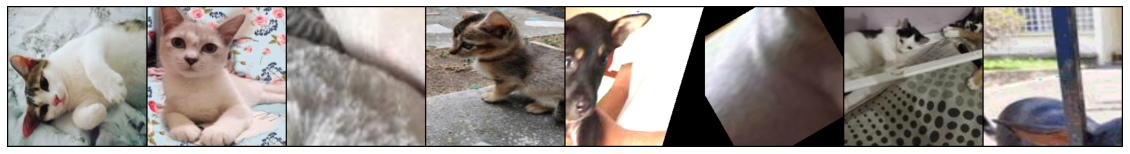

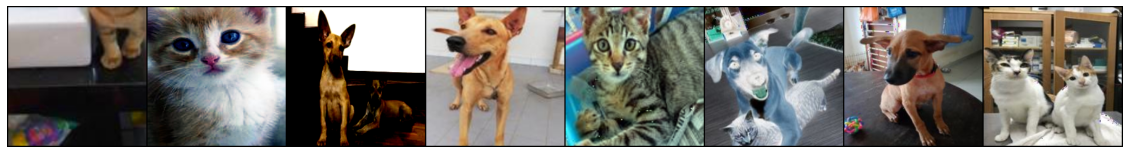

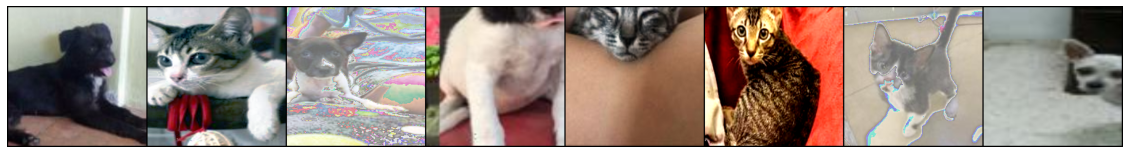

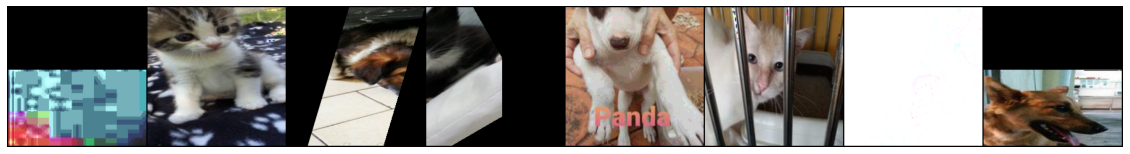

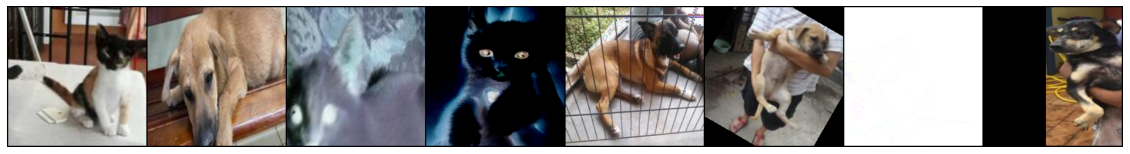

In [24]:
train_aug = transforms_factory.create_transform(
    input_size=224,
    is_training=True,
    auto_augment='rand-n2-m10',
    mean=(0,0,0),
    std=(1,1,1),
)
print(train_aug)

dm = ImageDataModule(
    task="classification",
    batch_size=8,
    # train
    train_image_paths=train_image_paths,
    train_targets=train_targets,
    train_augmentations=train_aug,
)
dm.setup()

plot_batches(dl=dm.train_dataloader(), n_batches=5)

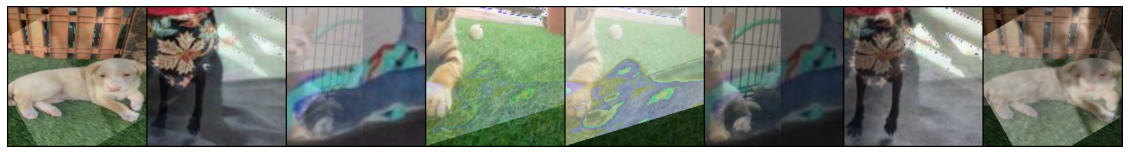

In [28]:
for batch in dm.train_dataloader():
    input, target = batch
    import torch
    target = torch.tensor([t / 100. for t in target])
    new_input, _  = mixup_fn(input, target)
    plot_batches((new_input, new_target))
    break

In [26]:
target

tensor([0.3100, 0.3700, 0.6500, 0.0200, 0.5100, 0.4300, 0.2100, 0.3700])

In [27]:
new_target

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])

In [32]:
def mixup(x: torch.Tensor, y: torch.Tensor, alpha: float = 1.0):
    assert alpha > 0, "alpha should be larger than 0"
    assert x.size(0) > 1, "Mixup cannot be applied to a single instance."

    
    import numpy as np
    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size()[0])
    mixed_x = lam * x + (1 - lam) * x[rand_index, :]
    target_a, target_b = y, y[rand_index]
    return mixed_x, target_a, target_b, lam

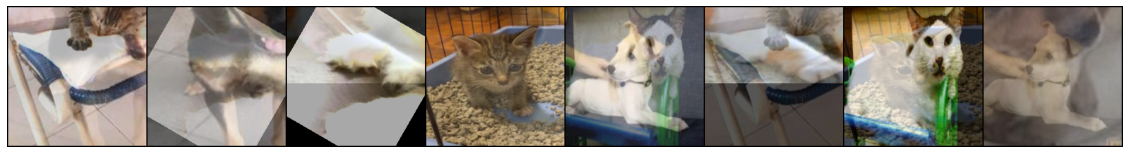

(tensor([0.4800, 0.3100, 0.9600, 0.3900, 0.5700, 0.2100, 0.2000, 0.7200]),
 tensor([0.4800, 0.3100, 0.9600, 0.3900, 0.5700, 0.2100, 0.2000, 0.7200]),
 tensor([0.3100, 0.9600, 0.2100, 0.7200, 0.2000, 0.4800, 0.3900, 0.5700]),
 0.6590148244325386)

In [50]:
for batch in dm.train_dataloader():
    input, target = batch
    target = torch.tensor([t / 100. for t in target])
    mixed_input, target_a, target_b, lam = mixup(input, target)
    plot_batches((mixed_input, target_a))
    break
    
target, target_a, target_b, lam